### 단일 변수 시계열 예측

Epoch [10/100], Loss: 0.0585
Epoch [20/100], Loss: 0.0155
Epoch [30/100], Loss: 0.0076
Epoch [40/100], Loss: 0.0035
Epoch [50/100], Loss: 0.0030
Epoch [60/100], Loss: 0.0027
Epoch [70/100], Loss: 0.0026
Epoch [80/100], Loss: 0.0026
Epoch [90/100], Loss: 0.0026
Epoch [100/100], Loss: 0.0025


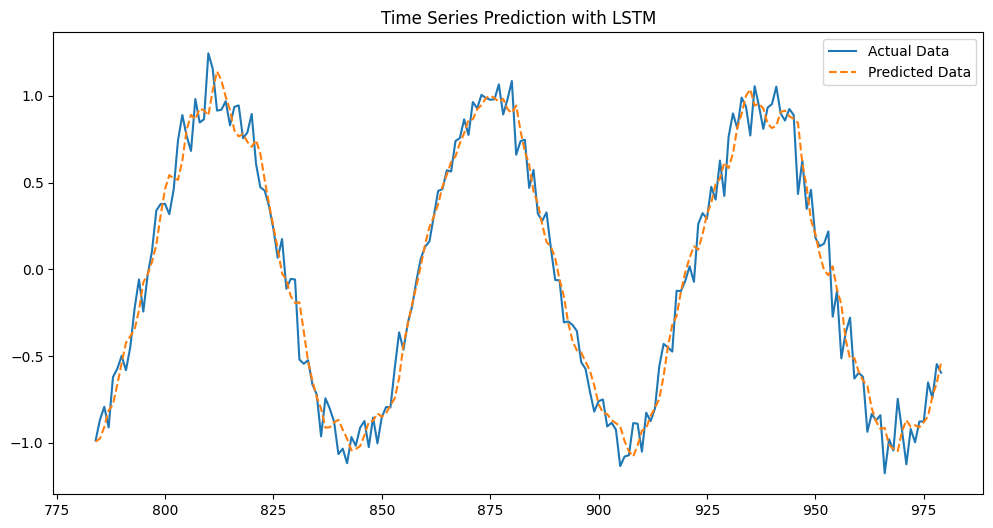

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# 1. 데이터 생성 (Synthetic Data: Sine Wave)
# 실제 데이터를 사용할 경우 pd.read_csv() 등으로 대체하세요.
t = np.linspace(0, 100, 1000)
data = np.sin(t) + 0.1 * np.random.randn(1000)  # 노이즈 추가

# 2. 데이터 전처리
# LSTM은 스케일에 민감하므로 MinMaxScaler 적용 (0~1 사이로 변환)
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data.reshape(-1, 1))

# 시퀀스 데이터 생성 함수 (Sliding Window)
# look_back: 과거 몇 개의 데이터를 보고 다음을 예측할지 결정
def create_sequences(data, look_back):
    xs, ys = [], []
    for i in range(len(data) - look_back):
        x = data[i:(i + look_back)]
        y = data[i + look_back]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

LOOK_BACK = 20  # 과거 20개의 데이터를 보고 1개를 예측
X, y = create_sequences(data_normalized, LOOK_BACK)

# 텐서 변환 (Batch Size, Sequence Length, Input Size)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# 학습/테스트 데이터 분리
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 3. LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM 레이어 (batch_first=True: 입력 차원이 (batch, seq, feature)가 됨)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # Fully Connected 레이어 (예측값 출력용)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # 초기 hidden state와 cell state 초기화
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # LSTM 순전파
        out, _ = self.lstm(x, (h0, c0))

        # 마지막 타임스텝의 출력만 사용 (Many-to-One 구조)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

# 하이퍼파라미터 설정
INPUT_SIZE = 1    # 특성 개수 (단변량 시계열이므로 1)
HIDDEN_SIZE = 64  # 은닉층 노드 수
OUTPUT_SIZE = 1   # 예측할 값의 개수
NUM_LAYERS = 1    # LSTM 층 수
LEARNING_RATE = 0.01
EPOCHS = 100

model = LSTMModel(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, NUM_LAYERS)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 4. 모델 학습
model.train()
for epoch in range(EPOCHS):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}')

# 5. 예측 및 시각화
model.eval()
with torch.no_grad():
    train_predict = model(X_train)
    test_predict = model(X_test)

# 스케일 역변환 (원래 값으로 복구)
train_predict = scaler.inverse_transform(train_predict.numpy())
test_predict = scaler.inverse_transform(test_predict.numpy())
y_test_actual = scaler.inverse_transform(y_test.numpy())

# 결과 시각화
plt.figure(figsize=(12, 6))
# 전체 데이터 중 테스트 구간의 실제 값
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_actual, label='Actual Data')
# 모델의 예측 값
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), test_predict, label='Predicted Data', linestyle='--')
plt.title('Time Series Prediction with LSTM')
plt.legend()
plt.show()

### 다중 변수 시계열 예측 many to one

Epoch [20/100], Loss: 0.0456
Epoch [40/100], Loss: 0.0188
Epoch [60/100], Loss: 0.0091
Epoch [80/100], Loss: 0.0064
Epoch [100/100], Loss: 0.0044


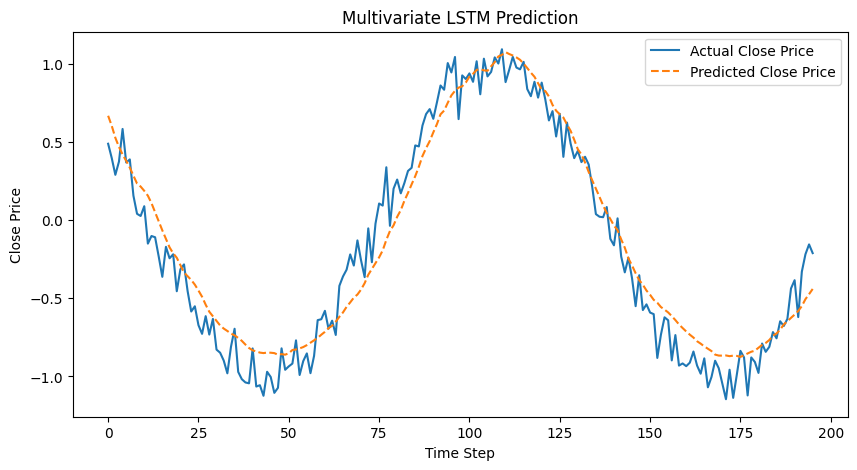

In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# 1. 가상 데이터 생성 (Open, High, Low, Volume, Close)
# 실제 데이터가 있다면 pd.read_csv()를 사용하세요.
np.random.seed(42)
days = 1000
data = {
    'Open': np.sin(np.linspace(0, 50, days)) + np.random.normal(0, 0.1, days),
    'High': np.sin(np.linspace(0, 50, days)) + 0.5 + np.random.normal(0, 0.1, days),
    'Low': np.sin(np.linspace(0, 50, days)) - 0.5 + np.random.normal(0, 0.1, days),
    'Volume': np.random.randint(100, 1000, days),
    'Close': np.sin(np.linspace(0, 50, days)) + np.random.normal(0, 0.1, days) # 타겟 변수
}
df = pd.DataFrame(data)

# 2. 데이터 전처리
# X(입력 변수들)와 y(타겟 변수)를 분리하여 스케일링하는 것이 inverse_transform 할 때 편리합니다.
feature_cols = ['Open', 'High', 'Low', 'Volume']
target_col = ['Close']

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_x.fit_transform(df[feature_cols])
y_scaled = scaler_y.fit_transform(df[target_col])

# 시퀀스 데이터 생성 (Sliding Window)
def create_sequences(X, y, look_back):
    xs, ys = [], []
    for i in range(len(X) - look_back):
        # i부터 i+look_back까지의 특징 데이터 (과거 데이터)
        xs.append(X[i:(i + look_back)])
        # i+look_back 시점의 타겟 데이터 (예측할 미래 값)
        ys.append(y[i + look_back])
    return np.array(xs), np.array(ys)

LOOK_BACK = 20
X_seq, y_seq = create_sequences(X_scaled, y_scaled, LOOK_BACK)

# 텐서 변환
# X shape: (Batch, Sequence Length, Input Features) -> (N, 20, 4)
# y shape: (Batch, Output Size) -> (N, 1)
X_tensor = torch.tensor(X_seq, dtype=torch.float32)
y_tensor = torch.tensor(y_seq, dtype=torch.float32)

# 학습/테스트 분리
train_size = int(len(X_tensor) * 0.8)
X_train, X_test = X_tensor[:train_size], X_tensor[train_size:]
y_train, y_test = y_tensor[:train_size], y_tensor[train_size:]

# 3. LSTM 모델 정의
class MultivariateLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(MultivariateLSTM, self).__init__()

        # batch_first=True: 입력 텐서의 첫 번째 차원이 batch size가 됨
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x shape: (Batch, Sequence, Features)
        out, _ = self.lstm(x)

        # 마지막 타임스텝의 출력만 사용
        # out shape: (Batch, Sequence, Hidden) -> 마지막 Sequence 선택 -> (Batch, Hidden)
        last_out = out[:, -1, :]

        prediction = self.fc(last_out)
        return prediction

# 하이퍼파라미터 설정
INPUT_SIZE = len(feature_cols) # 4개 (Open, High, Low, Volume)
HIDDEN_SIZE = 64
OUTPUT_SIZE = 1                # 1개 (Close 예측)
NUM_LAYERS = 2
LEARNING_RATE = 0.001
EPOCHS = 100

model = MultivariateLSTM(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, NUM_LAYERS)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 4. 학습
model.train()
for epoch in range(EPOCHS):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}')

# 5. 예측 및 결과 확인
model.eval()
with torch.no_grad():
    test_predict = model(X_test)

# 스케일 역변환 (Target 스케일러 사용)
test_predict_inv = scaler_y.inverse_transform(test_predict.numpy())
y_test_inv = scaler_y.inverse_transform(y_test.numpy())

# 시각화
plt.figure(figsize=(10, 5))
plt.plot(y_test_inv, label='Actual Close Price')
plt.plot(test_predict_inv, label='Predicted Close Price', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Close Price')
plt.legend()
plt.title('Multivariate LSTM Prediction')
plt.show()

### many to many

Epoch [20/100], Loss: 0.0768
Epoch [40/100], Loss: 0.0509
Epoch [60/100], Loss: 0.0370
Epoch [80/100], Loss: 0.0216
Epoch [100/100], Loss: 0.0123


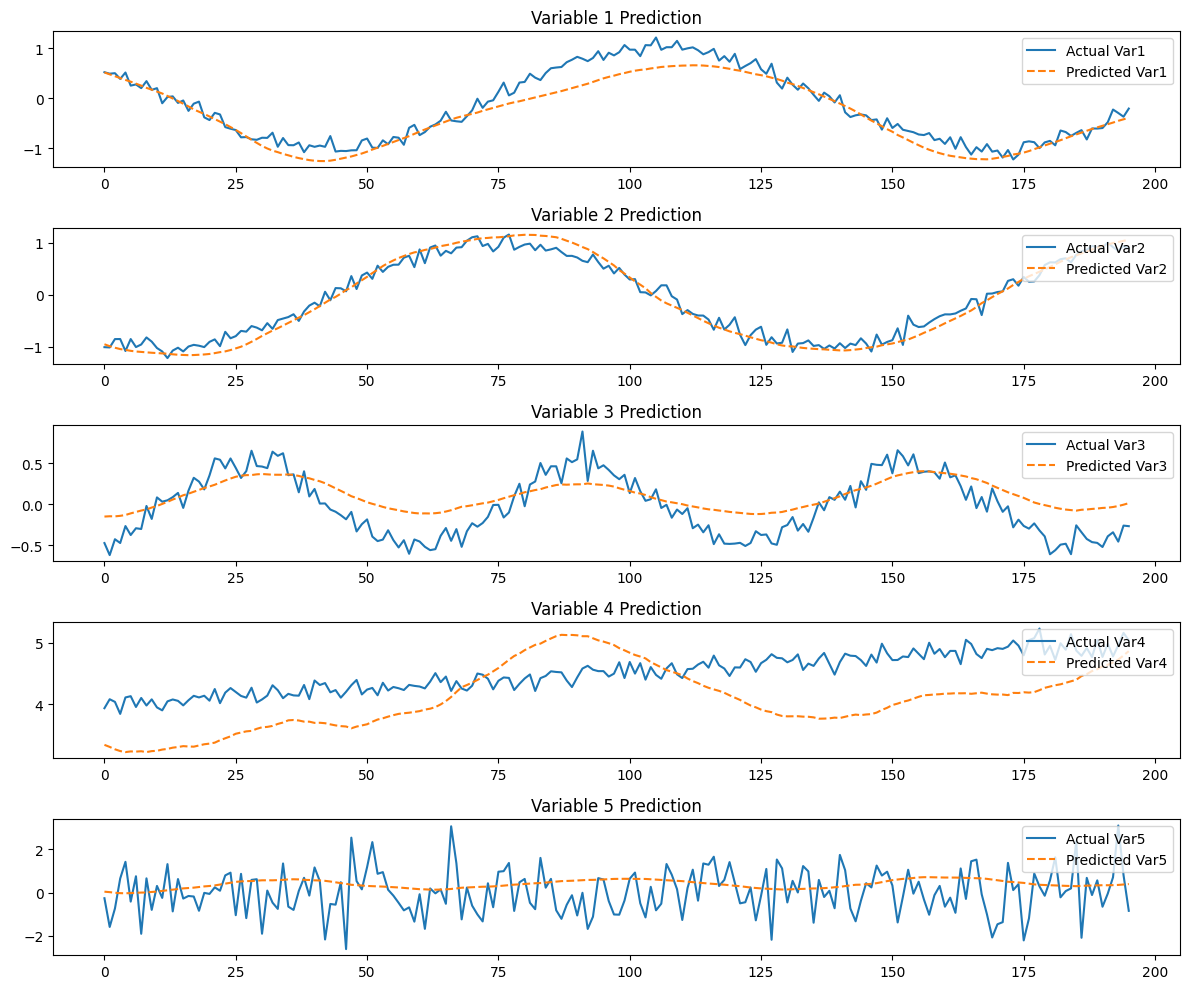

In [3]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# 1. 가상 데이터 생성 (5개 변수)
np.random.seed(42)
days = 1000
t = np.linspace(0, 50, days)
data = {
    'Var1': np.sin(t) + np.random.normal(0, 0.1, days),
    'Var2': np.cos(t) + np.random.normal(0, 0.1, days),
    'Var3': np.sin(t) * np.cos(t) + np.random.normal(0, 0.1, days),
    'Var4': t * 0.1 + np.random.normal(0, 0.1, days), # 우상향 추세
    'Var5': np.random.normal(0, 1, days) # 랜덤 노이즈
}
df = pd.DataFrame(data)

# 2. 데이터 전처리
# 입력과 타겟이 동일한 변수 집합이므로 하나의 Scaler만 사용해도 됩니다.
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

# 시퀀스 생성 함수
def create_sequences(data, look_back):
    xs, ys = [], []
    for i in range(len(data) - look_back):
        # 입력: 과거 look_back 만큼의 모든 변수 데이터
        xs.append(data[i:(i + look_back)])
        # 출력: 바로 다음 시점의 '모든 변수' 데이터
        ys.append(data[i + look_back])
    return np.array(xs), np.array(ys)

LOOK_BACK = 20
X_seq, y_seq = create_sequences(df_scaled, LOOK_BACK)

# 텐서 변환
# X shape: (Batch, Sequence, Features) -> (N, 20, 5)
# y shape: (Batch, Features) -> (N, 5) <-- 여기가 핵심 변화
X_tensor = torch.tensor(X_seq, dtype=torch.float32)
y_tensor = torch.tensor(y_seq, dtype=torch.float32)

# 학습/테스트 분리
train_size = int(len(X_tensor) * 0.8)
X_train, X_test = X_tensor[:train_size], X_tensor[train_size:]
y_train, y_test = y_tensor[:train_size], y_tensor[train_size:]

# 3. LSTM 모델 정의
class MultiOutputLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(MultiOutputLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        last_out = out[:, -1, :] # 마지막 타임스텝의 Hidden State
        prediction = self.fc(last_out)
        return prediction

# 하이퍼파라미터 설정
INPUT_SIZE = df.shape[1]  # 5개
OUTPUT_SIZE = df.shape[1] # 5개 (입력 개수와 동일하게 설정)
HIDDEN_SIZE = 64
NUM_LAYERS = 2
LEARNING_RATE = 0.001
EPOCHS = 100

model = MultiOutputLSTM(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, NUM_LAYERS)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 4. 학습
model.train()
loss_history = []
for epoch in range(EPOCHS):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())

    if (epoch+1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}')

# 5. 예측 및 결과 시각화
model.eval()
with torch.no_grad():
    test_predict = model(X_test)

# 역변환 (전체 변수에 대해 한 번에 수행)
test_predict_inv = scaler.inverse_transform(test_predict.numpy())
y_test_inv = scaler.inverse_transform(y_test.numpy())

# 시각화 (각 변수별로 그래프 그리기)
num_features = df.shape[1]
plt.figure(figsize=(12, 10))

for i in range(num_features):
    plt.subplot(num_features, 1, i+1)
    plt.plot(y_test_inv[:, i], label=f'Actual Var{i+1}')
    plt.plot(test_predict_inv[:, i], label=f'Predicted Var{i+1}', linestyle='--')
    plt.legend(loc='upper right')
    plt.title(f'Variable {i+1} Prediction')

plt.tight_layout()
plt.show()

Epoch [20/100], Loss: 0.0161
Epoch [40/100], Loss: 0.0051
Epoch [60/100], Loss: 0.0031
Epoch [80/100], Loss: 0.0024
Epoch [100/100], Loss: 0.0022


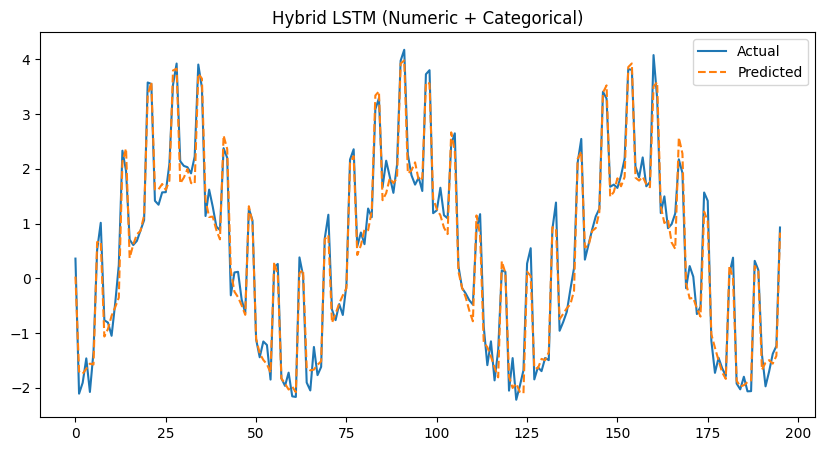

In [4]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# 1. 가상 데이터 생성 (수치형 + 범주형)
num_samples = 1000
time = np.arange(num_samples)

# 범주형 변수: 요일(0~6), 날씨(0~3)
day_of_week = time % 7
weather = np.random.randint(0, 4, num_samples)

# 수치형 변수: 기온, 습도 (임의 생성)
temp = np.sin(time * 0.1) + np.random.normal(0, 0.1, num_samples)
humidity = np.cos(time * 0.1) + np.random.normal(0, 0.1, num_samples)

# 타겟 변수: 전력 사용량 (요일과 기온의 영향을 받는다고 가정)
# 주말(5,6)에는 사용량이 늘고, 기온이 높으면 사용량이 늠
target = temp * 2 + (day_of_week >= 5) * 2 + np.random.normal(0, 0.1, num_samples)

df = pd.DataFrame({
    'day': day_of_week,
    'weather': weather,
    'temp': temp,
    'humidity': humidity,
    'target': target
})

# 2. 데이터 전처리
# 범주형 컬럼과 수치형 컬럼 정의
cat_cols = ['day', 'weather']
num_cols = ['temp', 'humidity']
target_col = ['target']

# 수치형 데이터 스케일링
scaler_num = MinMaxScaler()
df[num_cols] = scaler_num.fit_transform(df[num_cols])

scaler_target = MinMaxScaler()
df[target_col] = scaler_target.fit_transform(df[target_col])

# 범주형 데이터 Label Encoding (이미 숫자로 되어있지만, 문자열일 경우 필수)
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# 시퀀스 생성 함수 (수치형과 범주형을 따로 리스트에 담음)
def create_sequences(df, look_back):
    num_data = df[num_cols].values
    cat_data = df[cat_cols].values
    target_data = df[target_col].values

    xs_num, xs_cat, ys = [], [], []
    for i in range(len(df) - look_back):
        xs_num.append(num_data[i:(i + look_back)])
        xs_cat.append(cat_data[i:(i + look_back)])
        ys.append(target_data[i + look_back])

    return np.array(xs_num), np.array(xs_cat), np.array(ys)

LOOK_BACK = 20
X_num, X_cat, y = create_sequences(df, LOOK_BACK)

# 텐서 변환
# 범주형은 Embedding 레이어에 들어가야 하므로 LongTensor(정수형)여야 함
X_num_tensor = torch.tensor(X_num, dtype=torch.float32)
X_cat_tensor = torch.tensor(X_cat, dtype=torch.long)
y_tensor = torch.tensor(y, dtype=torch.float32)

# 학습/테스트 분리
train_size = int(len(X_num_tensor) * 0.8)
X_num_train, X_num_test = X_num_tensor[:train_size], X_num_tensor[train_size:]
X_cat_train, X_cat_test = X_cat_tensor[:train_size], X_cat_tensor[train_size:]
y_train, y_test = y_tensor[:train_size], y_tensor[train_size:]

# 3. 모델 정의 (Embedding + LSTM)
class HybridLSTM(nn.Module):
    def __init__(self, num_input_dim, cat_dims, embedding_dims, hidden_size, output_size):
        super(HybridLSTM, self).__init__()

        # 범주형 변수들을 위한 임베딩 레이어 리스트
        # cat_dims: [7, 4] (요일 7개, 날씨 4개)
        # embedding_dims: [3, 2] (요일을 3차원으로, 날씨를 2차원으로 축소)
        self.embeddings = nn.ModuleList([
            nn.Embedding(num_embeddings=dim, embedding_dim=emb_dim)
            for dim, emb_dim in zip(cat_dims, embedding_dims)
        ])

        # LSTM 입력 차원 = 수치형 변수 개수 + 모든 임베딩 차원의 합
        total_input_size = num_input_dim + sum(embedding_dims)

        self.lstm = nn.LSTM(total_input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x_num, x_cat):
        # x_cat shape: (Batch, Seq, Num_Cat_Features) -> (N, 20, 2)

        embedded_list = []
        for i, emb_layer in enumerate(self.embeddings):
            # 각 범주형 변수를 해당 임베딩 레이어에 통과시킴
            # x_cat[:, :, i] shape: (Batch, Seq) -> Embedding -> (Batch, Seq, Emb_Dim)
            embedded_list.append(emb_layer(x_cat[:, :, i]))

        # 모든 임베딩 벡터를 이어 붙임 (Concatenate)
        x_emb = torch.cat(embedded_list, dim=2)

        # 수치형 데이터와 임베딩된 범주형 데이터를 합침
        # (Batch, Seq, Num_Cont) + (Batch, Seq, Total_Emb) -> (Batch, Seq, Total_Input)
        x_combined = torch.cat([x_num, x_emb], dim=2)

        out, _ = self.lstm(x_combined)
        out = out[:, -1, :] # 마지막 타임스텝
        out = self.dropout(out)
        return self.fc(out)

# 하이퍼파라미터 설정
CAT_DIMS = [7, 4]        # 각 범주형 변수의 고유값 개수 (요일 7개, 날씨 4개)
EMB_DIMS = [3, 2]        # 임베딩 차원 (보통 고유값 개수의 절반 정도로 설정)
NUM_INPUT_DIM = 2        # 수치형 변수 개수 (기온, 습도)
HIDDEN_SIZE = 64
OUTPUT_SIZE = 1

model = HybridLSTM(NUM_INPUT_DIM, CAT_DIMS, EMB_DIMS, HIDDEN_SIZE, OUTPUT_SIZE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 4. 학습
model.train()
for epoch in range(100):
    optimizer.zero_grad()
    # 수치형과 범주형 입력을 같이 넣어줌
    outputs = model(X_num_train, X_cat_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 20 == 0:
        print(f'Epoch [{epoch+1}/100], Loss: {loss.item():.4f}')

# 5. 예측 및 시각화
model.eval()
with torch.no_grad():
    test_predict = model(X_num_test, X_cat_test)

test_predict_inv = scaler_target.inverse_transform(test_predict.numpy())
y_test_inv = scaler_target.inverse_transform(y_test.numpy())

plt.figure(figsize=(10, 5))
plt.plot(y_test_inv, label='Actual')
plt.plot(test_predict_inv, label='Predicted', linestyle='--')
plt.legend()
plt.title('Hybrid LSTM (Numeric + Categorical)')
plt.show()

Epoch [10/50], Loss: 0.6935, Acc: 0.5000
Epoch [20/50], Loss: 0.6931, Acc: 0.5000
Epoch [30/50], Loss: 0.6928, Acc: 0.5000
Epoch [40/50], Loss: 0.6925, Acc: 0.5475
Epoch [50/50], Loss: 0.6920, Acc: 0.5288

=== Test Results ===
Final Accuracy: 58.50%
Confusion Matrix:
[[77 32]
 [51 40]]


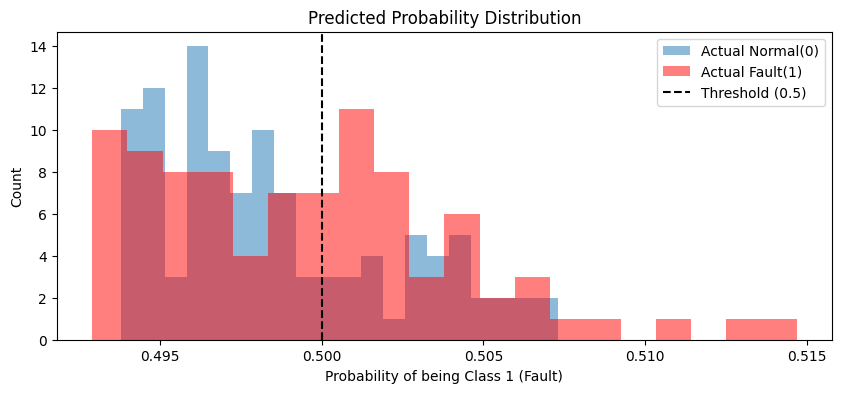

In [5]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# 1. 가상 데이터 생성 (정상 vs 고장)
# N개의 시계열 샘플을 만듭니다. 각 샘플의 길이는 seq_len입니다.
N_SAMPLES = 1000
SEQ_LEN = 50

X_data = []
y_data = []

for i in range(N_SAMPLES):
    # 기본 파형
    t = np.linspace(0, 10, SEQ_LEN)
    wave = np.sin(t + np.random.rand()) # 위상 랜덤

    # 50% 확률로 정상(0) 또는 고장(1) 데이터 생성
    if np.random.rand() > 0.5:
        # Class 1: 고장 (노이즈가 심함)
        noise = np.random.normal(0, 0.5, SEQ_LEN)
        sequence = wave + noise
        label = 1
    else:
        # Class 0: 정상 (약간의 노이즈)
        noise = np.random.normal(0, 0.1, SEQ_LEN)
        sequence = wave + noise
        label = 0

    X_data.append(sequence)
    y_data.append(label)

X_data = np.array(X_data)
y_data = np.array(y_data)

# 데이터 차원: (Sample 수, 시퀀스 길이, 변수 개수) -> (1000, 50, 1)
X_data = np.expand_dims(X_data, axis=2)

# 학습/테스트 분리
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# 텐서 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1) # (N, 1) 형태 필수
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# 2. LSTM 분류 모델 정의
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # 이진 분류이므로 출력은 1개 (0~1 사이의 확률값으로 변환될 로짓)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x shape: (Batch, Seq, Feature)
        _, (hidden, _) = self.lstm(x)

        # hidden shape: (Num_Layers, Batch, Hidden)
        # 마지막 층의 hidden state만 사용
        last_hidden = hidden[-1, :, :]

        out = self.fc(last_hidden)
        return out

# 하이퍼파라미터
INPUT_SIZE = 1
HIDDEN_SIZE = 32
NUM_LAYERS = 1
LEARNING_RATE = 0.001
EPOCHS = 50

model = LSTMClassifier(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS)

# 3. Loss Function 및 Optimizer
# BCEWithLogitsLoss: Sigmoid 레이어와 BCELoss를 합친 것 (수치적으로 더 안정적)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 4. 학습
model.train()
for epoch in range(EPOCHS):
    optimizer.zero_grad()
    outputs = model(X_train) # 결과는 확률이 아닌 Logits 값
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    # 정확도 계산 (학습 중 모니터링)
    with torch.no_grad():
        probs = torch.sigmoid(outputs) # 확률로 변환 (0.0 ~ 1.0)
        preds = (probs > 0.5).float()  # 0.5 기준 분류
        acc = (preds == y_train).float().mean()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}, Acc: {acc.item():.4f}')

# 5. 평가 및 결과 확인
model.eval()
with torch.no_grad():
    test_logits = model(X_test)
    test_probs = torch.sigmoid(test_logits) # 확률값
    test_preds = (test_probs > 0.5).float() # 0 or 1 예측값

# 결과 출력
acc = accuracy_score(y_test, test_preds)
cm = confusion_matrix(y_test, test_preds)

print("\n=== Test Results ===")
print(f"Final Accuracy: {acc*100:.2f}%")
print("Confusion Matrix:")
print(cm)

# 시각화: 확률 분포 확인
plt.figure(figsize=(10, 4))
plt.hist(test_probs.numpy()[y_test.numpy()==0], bins=20, alpha=0.5, label='Actual Normal(0)')
plt.hist(test_probs.numpy()[y_test.numpy()==1], bins=20, alpha=0.5, label='Actual Fault(1)', color='red')
plt.axvline(0.5, color='k', linestyle='--', label='Threshold (0.5)')
plt.title('Predicted Probability Distribution')
plt.xlabel('Probability of being Class 1 (Fault)')
plt.ylabel('Count')
plt.legend()
plt.show()

### 시계열 이진분류 모델


- 지난 10건의 데이터를 보고 현재가 사기인지 예측.

Epoch 10/50, Loss: 0.9850, Train Acc: 0.3184
Epoch 20/50, Loss: 0.9836, Train Acc: 0.3695
Epoch 30/50, Loss: 0.9828, Train Acc: 0.4088
Epoch 40/50, Loss: 0.9817, Train Acc: 0.4316
Epoch 50/50, Loss: 0.9793, Train Acc: 0.4459

Classification Report:
              precision    recall  f1-score   support

      Normal       0.66      0.25      0.36       681
       Fraud       0.31      0.72      0.43       317

    accuracy                           0.40       998
   macro avg       0.48      0.49      0.40       998
weighted avg       0.55      0.40      0.38       998

Confusion Matrix:
[[169 512]
 [ 88 229]]


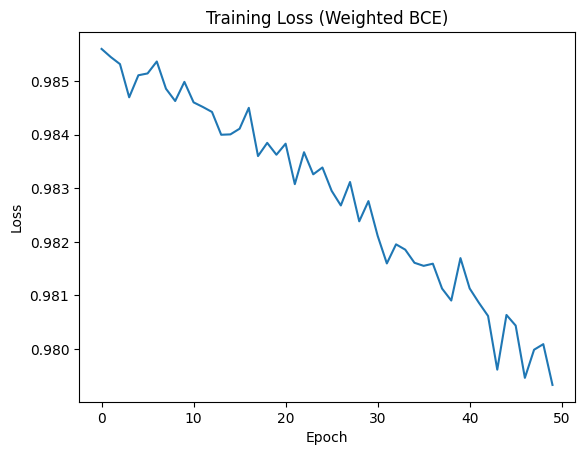

In [8]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import f1_score, confusion_matrix, classification_report

# 1. 가상 카드 거래 데이터 생성
# 상황: 사용자의 최근 10건(seq_len) 거래를 보고, 현재 거래가 사기인지 예측
num_samples = 5000
seq_len = 10

# 범주형: 가맹점 카테고리(0~4), 지역 코드(0~9)
# 수치형: 거래 금액(Amount), 시간 간격(Time Delta)
data = {
    'category': np.random.randint(0, 5, num_samples),
    'region': np.random.randint(0, 10, num_samples),
    'amount': np.random.exponential(50, num_samples), # 금액은 지수분포 따름
    'time_delta': np.random.randint(1, 3600, num_samples),
}
df = pd.DataFrame(data)

# 타겟 생성 (비율 3:7 설정)
# 사기(1) : 정상(0) = 3 : 7
y_indices = np.random.choice([0, 1], size=num_samples, p=[0.7, 0.3])
df['is_fraud'] = y_indices

# 사기 거래 패턴 심기 (예: 특정 카테고리에서 고액 결제 시 사기 확률 높음)
mask = (df['category'] == 4) & (df['amount'] > 100)
df.loc[mask, 'is_fraud'] = 1

# 2. 데이터 전처리
cat_cols = ['category', 'region']
num_cols = ['amount', 'time_delta']

# 수치형 스케일링
scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# 범주형 인코딩 (LabelEncoder)
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# 시퀀스 데이터 생성 (User별로 묶어야 하지만, 여기선 단순 슬라이딩 윈도우)
def create_sequences(df, seq_len):
    num_vals = df[num_cols].values
    cat_vals = df[cat_cols].values
    targets = df['is_fraud'].values

    xs_num, xs_cat, ys = [], [], []

    for i in range(len(df) - seq_len):
        xs_num.append(num_vals[i : i+seq_len])
        xs_cat.append(cat_vals[i : i+seq_len])
        ys.append(targets[i+seq_len]) # 시퀀스 끝난 직후 거래의 사기 여부

    return np.array(xs_num), np.array(xs_cat), np.array(ys)

X_num, X_cat, y = create_sequences(df, seq_len)

# 학습/검증 분리 (Stratify로 클래스 비율 유지)
X_num_train, X_num_test, X_cat_train, X_cat_test, y_train, y_test = train_test_split(
    X_num, X_cat, y, test_size=0.2, stratify=y, random_state=42
)

# 텐서 변환
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_num_train = torch.tensor(X_num_train, dtype=torch.float32).to(device)
X_cat_train = torch.tensor(X_cat_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)

X_num_test = torch.tensor(X_num_test, dtype=torch.float32).to(device)
X_cat_test = torch.tensor(X_cat_test, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)

# 3. 모델 정의 (Embedding + LSTM)
class FraudLSTM(nn.Module):
    def __init__(self, num_input_dim, cat_dims, emb_dims, hidden_size):
        super(FraudLSTM, self).__init__()

        # 임베딩 레이어들
        self.embeddings = nn.ModuleList([
            nn.Embedding(dim, emb_dim) for dim, emb_dim in zip(cat_dims, emb_dims)
        ])

        # LSTM 입력 크기 = 수치형 개수 + 임베딩 차원 합
        input_size = num_input_dim + sum(emb_dims)

        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=2, dropout=0.2)
        self.fc = nn.Linear(hidden_size, 1) # 이진 분류
        self.dropout = nn.Dropout(0.3)

    def forward(self, x_num, x_cat):
        # x_cat: (Batch, Seq, Cat_Features)
        emb_list = []
        for i, emb in enumerate(self.embeddings):
            emb_list.append(emb(x_cat[:, :, i]))

        x_emb = torch.cat(emb_list, dim=2)

        # (Batch, Seq, Num) + (Batch, Seq, Emb_Total)
        x_combined = torch.cat([x_num, x_emb], dim=2)

        # LSTM 통과
        out, _ = self.lstm(x_combined)

        # 마지막 타임스텝 사용
        last_out = out[:, -1, :]
        last_out = self.dropout(last_out)

        return self.fc(last_out)

# 하이퍼파라미터
CAT_DIMS = [5, 10]   # 카테고리 5개, 지역 10개
EMB_DIMS = [3, 4]    # 임베딩 차원 설정
NUM_INPUT = 2        # Amount, Time_Delta
HIDDEN_SIZE = 64

model = FraudLSTM(NUM_INPUT, CAT_DIMS, EMB_DIMS, HIDDEN_SIZE).to(device)

# 4. 불균형 데이터 처리를 위한 Loss Weight 설정
# 클래스 0(정상) : 클래스 1(사기) = 7 : 3
# 사기(1)를 틀렸을 때 더 큰 페널티를 부여 (비율의 역수 적용)
# pos_weight = (Number of Negatives) / (Number of Positives) = 7 / 3 ≈ 2.33
pos_weight = torch.tensor([7.0 / 3.0]).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 5. 학습 루프
epochs = 50
train_losses = []

model.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_num_train, X_cat_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    if (epoch+1) % 10 == 0:
        # F1 Score 간단 확인
        preds = (torch.sigmoid(outputs) > 0.5).float()
        acc = (preds == y_train).float().mean()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Train Acc: {acc:.4f}")

# 6. 평가 (Confusion Matrix & F1 Score)
model.eval()
with torch.no_grad():
    y_logits = model(X_num_test, X_cat_test)
    y_probs = torch.sigmoid(y_logits)
    y_preds = (y_probs > 0.5).float() # Threshold 0.5 (상황에 따라 조정 가능)

# CPU로 가져와서 sklearn 계산
y_test_np = y_test.cpu().numpy()
y_preds_np = y_preds.cpu().numpy()

print("\nClassification Report:")
print(classification_report(y_test_np, y_preds_np, target_names=['Normal', 'Fraud']))

print("Confusion Matrix:")
cm = confusion_matrix(y_test_np, y_preds_np)
print(cm)

# 시각화 (Loss)
plt.plot(train_losses)
plt.title('Training Loss (Weighted BCE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### 고객 ID별로

In [9]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import f1_score, classification_report
from tqdm import tqdm # 진행상황바 표시용

# 1. 가상 데이터 생성 (고객 ID 포함)
np.random.seed(42)
num_samples = 10000
num_customers = 500  # 500명의 고객

data = {
    'customer_id': np.random.randint(0, num_customers, num_samples),
    'timestamp': pd.date_range(start='2023-01-01', periods=num_samples, freq='T').astype(int), # 시간 정렬용
    'category': np.random.randint(0, 5, num_samples),
    'region': np.random.randint(0, 10, num_samples),
    'amount': np.random.exponential(50, num_samples),
    'is_fraud': np.random.choice([0, 1], size=num_samples, p=[0.7, 0.3]) # 3:7 비율
}
df = pd.DataFrame(data)

# 2. 데이터 전처리
# ★중요★: 반드시 고객별, 시간순으로 정렬해야 함
df = df.sort_values(by=['customer_id', 'timestamp']).reset_index(drop=True)

cat_cols = ['category', 'region']
num_cols = ['amount'] # time_delta는 복잡해지니 제외하고 금액만 사용

# 스케일링 & 인코딩
scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# 3. 고객별 시퀀스 생성 함수
def create_sequences_by_user(df, seq_len):
    xs_num, xs_cat, ys = [], [], []

    # 고객 ID로 그룹화하여 처리
    grouped = df.groupby('customer_id')

    for customer_id, group in tqdm(grouped, desc="Generating Sequences"):
        # 해당 고객의 데이터만 추출
        num_vals = group[num_cols].values
        cat_vals = group[cat_cols].values
        targets = group['is_fraud'].values

        # 데이터가 시퀀스 길이보다 짧으면 건너뜀 (최소 과거 데이터 필요)
        if len(group) < seq_len + 1:
            continue

        for i in range(len(group) - seq_len):
            # 입력: 과거 10건
            xs_num.append(num_vals[i : i+seq_len])
            xs_cat.append(cat_vals[i : i+seq_len])
            # 출력: 바로 다음 1건의 사기 여부
            ys.append(targets[i+seq_len])

    return np.array(xs_num), np.array(xs_cat), np.array(ys)

SEQ_LEN = 10
X_num, X_cat, y = create_sequences_by_user(df, SEQ_LEN)

print(f"\n생성된 시퀀스 개수: {len(y)}")

# 학습/검증 분리
X_num_train, X_num_test, X_cat_train, X_cat_test, y_train, y_test = train_test_split(
    X_num, X_cat, y, test_size=0.2, stratify=y, random_state=42
)

# 텐서 변환
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_num_train = torch.tensor(X_num_train, dtype=torch.float32).to(device)
X_cat_train = torch.tensor(X_cat_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)

X_num_test = torch.tensor(X_num_test, dtype=torch.float32).to(device)
X_cat_test = torch.tensor(X_cat_test, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)

# 4. 모델 정의 (이전과 동일)
class FraudLSTM(nn.Module):
    def __init__(self, num_input_dim, cat_dims, emb_dims, hidden_size):
        super(FraudLSTM, self).__init__()
        self.embeddings = nn.ModuleList([
            nn.Embedding(dim, emb_dim) for dim, emb_dim in zip(cat_dims, emb_dims)
        ])
        input_size = num_input_dim + sum(emb_dims)
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=2, dropout=0.2)
        self.fc = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x_num, x_cat):
        emb_list = [emb(x_cat[:, :, i]) for i, emb in enumerate(self.embeddings)]
        x_emb = torch.cat(emb_list, dim=2)
        x_combined = torch.cat([x_num, x_emb], dim=2)

        out, _ = self.lstm(x_combined)
        return self.fc(self.dropout(out[:, -1, :]))

# 하이퍼파라미터
CAT_DIMS = [5, 10]
EMB_DIMS = [3, 4]
NUM_INPUT = 1 # Amount
HIDDEN_SIZE = 64

model = FraudLSTM(NUM_INPUT, CAT_DIMS, EMB_DIMS, HIDDEN_SIZE).to(device)

# 5. 불균형 데이터 가중치 Loss (3:7 비율 고려)
pos_weight = torch.tensor([7.0 / 3.0]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 6. 학습
model.train()
for epoch in range(30):
    optimizer.zero_grad()
    outputs = model(X_num_train, X_cat_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# 7. 평가
model.eval()
with torch.no_grad():
    y_logits = model(X_num_test, X_cat_test)
    y_preds = (torch.sigmoid(y_logits) > 0.5).float().cpu().numpy()
    y_true = y_test.cpu().numpy()

print("\n=== Classification Report ===")
print(classification_report(y_true, y_preds, target_names=['Normal', 'Fraud']))

/tmp/ipython-input-855337474.py:17: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  'timestamp': pd.date_range(start='2023-01-01', periods=num_samples, freq='T').astype(int), # 시간 정렬용
Generating Sequences: 100%|██████████| 500/500 [00:00<00:00, 1000.73it/s]



생성된 시퀀스 개수: 5011
Epoch 5, Loss: 0.9738
Epoch 10, Loss: 0.9735
Epoch 15, Loss: 0.9731
Epoch 20, Loss: 0.9729
Epoch 25, Loss: 0.9730
Epoch 30, Loss: 0.9724

=== Classification Report ===
              precision    recall  f1-score   support

      Normal       0.71      0.40      0.51       698
       Fraud       0.31      0.63      0.42       305

    accuracy                           0.47      1003
   macro avg       0.51      0.51      0.46      1003
weighted avg       0.59      0.47      0.48      1003



### 이 데이터로 FDS 모델

In [13]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tqdm import tqdm

# 1. 가상 데이터 생성 (고객 ID 포함)
np.random.seed(42)
num_samples = 10000
num_customers = 500

data = {
    'customer_id': np.random.randint(0, num_customers, num_samples),
    'timestamp': pd.date_range(start='2023-01-01', periods=num_samples, freq='T').astype(int),
    'category': np.random.randint(0, 5, num_samples),
    'region': np.random.randint(0, 10, num_samples),
    'amount': np.random.exponential(50, num_samples),
    'is_fraud': np.random.choice([0, 1], size=num_samples, p=[0.85, 0.15]) # 15% 사기
}
df = pd.DataFrame(data)

# 데이터 정렬 (고객별, 시간순)
df = df.sort_values(by=['customer_id', 'timestamp']).reset_index(drop=True)

# 전처리 (스케일링 & 인코딩)
scaler = MinMaxScaler()
df[['amount']] = scaler.fit_transform(df[['amount']])

cat_cols = ['category', 'region']
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# ★ 핵심: 학습용(Normal Only)과 테스트용(Normal + Fraud) 분리
train_df = df[df['is_fraud'] == 0].copy() # 학습은 정상 데이터로만!
test_df = df.copy() # 테스트는 전체 데이터로 검증

# 시퀀스 생성 함수 (AutoEncoder는 Input == Target)
def create_sequences_for_ae(df, seq_len):
    grouped = df.groupby('customer_id')
    xs_num, xs_cat, labels = [], [], []

    for _, group in tqdm(grouped, desc="Sequencing"):
        if len(group) < seq_len:
            continue

        num_vals = group[['amount']].values
        cat_vals = group[cat_cols].values
        label_vals = group['is_fraud'].values

        for i in range(len(group) - seq_len + 1):
            # Input Sequence
            xs_num.append(num_vals[i : i+seq_len])
            xs_cat.append(cat_vals[i : i+seq_len])
            # 해당 시퀀스에 사기가 하나라도 포함되어 있는지 확인 (검증용 레이블)
            # 여기서는 시퀀스의 마지막 거래가 사기인지 아닌지를 기준으로 함
            labels.append(label_vals[i+seq_len-1])

    return np.array(xs_num), np.array(xs_cat), np.array(labels)

SEQ_LEN = 10

# 학습 데이터 생성 (정상만)
print("Creating Training Sequences (Normal Only)...")
X_num_train, X_cat_train, _ = create_sequences_for_ae(train_df, SEQ_LEN)

# 테스트 데이터 생성 (정상 + 사기)
print("Creating Test Sequences (Mixed)...")
X_num_test, X_cat_test, y_test = create_sequences_for_ae(test_df, SEQ_LEN)

# 텐서 변환
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_num_train = torch.tensor(X_num_train, dtype=torch.float32).to(device)
X_cat_train = torch.tensor(X_cat_train, dtype=torch.long).to(device)

X_num_test = torch.tensor(X_num_test, dtype=torch.float32).to(device)
X_cat_test = torch.tensor(X_cat_test, dtype=torch.long).to(device)

/tmp/ipython-input-2367707379.py:17: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  'timestamp': pd.date_range(start='2023-01-01', periods=num_samples, freq='T').astype(int),


Creating Training Sequences (Normal Only)...


Sequencing: 100%|██████████| 500/500 [00:00<00:00, 771.34it/s]


Creating Test Sequences (Mixed)...


Sequencing: 100%|██████████| 500/500 [00:00<00:00, 1124.55it/s]


In [14]:
class LSTMAutoEncoder(nn.Module):
    def __init__(self, num_input_dim, cat_dims, emb_dims, hidden_size, seq_len):
        super(LSTMAutoEncoder, self).__init__()
        self.seq_len = seq_len

        # 1. Embedding Layers
        self.embeddings = nn.ModuleList([
            nn.Embedding(dim, emb_dim) for dim, emb_dim in zip(cat_dims, emb_dims)
        ])

        # Total Feature Dimension
        self.input_dim = num_input_dim + sum(emb_dims)

        # 2. Encoder
        self.encoder_lstm = nn.LSTM(self.input_dim, hidden_size, batch_first=True)

        # 3. Decoder
        self.decoder_lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.output_layer = nn.Linear(hidden_size, self.input_dim) # 다시 원래 차원으로 복구

    def forward(self, x_num, x_cat):
        # --- Embedding & Concatenation ---
        emb_list = [emb(x_cat[:, :, i]) for i, emb in enumerate(self.embeddings)]
        x_emb = torch.cat(emb_list, dim=2)
        x_input = torch.cat([x_num, x_emb], dim=2) # (Batch, Seq, Feature)

        # --- Encoder ---
        # Encoder의 마지막 hidden state가 Latent Vector가 됨
        _, (hidden, _) = self.encoder_lstm(x_input)
        # hidden: (1, Batch, Hidden) -> (Batch, Hidden)
        latent = hidden[-1]

        # --- Decoder ---
        # Latent Vector를 시퀀스 길이만큼 반복해서 Decoder의 입력으로 사용
        # (Batch, Hidden) -> (Batch, Seq_Len, Hidden)
        decoder_input = latent.unsqueeze(1).repeat(1, self.seq_len, 1)

        decoded, _ = self.decoder_lstm(decoder_input)

        # --- Output ---
        reconstructed = self.output_layer(decoded)

        return reconstructed, x_input # Loss 계산을 위해 원본(x_input)도 리턴

# 모델 초기화
CAT_DIMS = [5, 10]
EMB_DIMS = [3, 4]
NUM_INPUT = 1
HIDDEN_SIZE = 64

model = LSTMAutoEncoder(NUM_INPUT, CAT_DIMS, EMB_DIMS, HIDDEN_SIZE, SEQ_LEN).to(device)
criterion = nn.MSELoss() # 입력과 재구성 값 사이의 차이 최소화
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Start Training...
Epoch 10, Loss: 0.6449
Epoch 20, Loss: 0.5842
Epoch 30, Loss: 0.5629
Epoch 40, Loss: 0.5419
Epoch 50, Loss: 0.5179


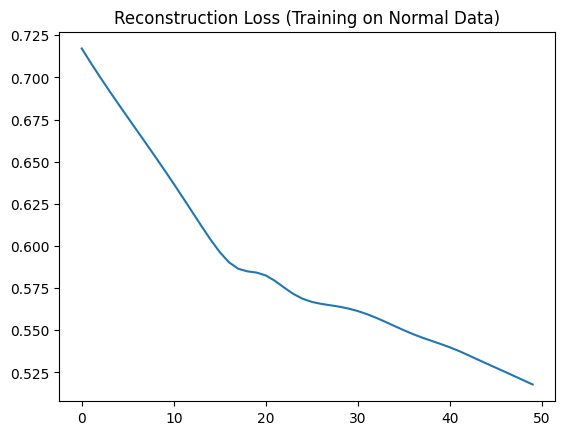

In [15]:
epochs = 50
model.train()
loss_history = []

print("Start Training...")
for epoch in range(epochs):
    optimizer.zero_grad()

    # AutoEncoder는 입력이 곧 타겟
    reconstructed, original = model(X_num_train, X_cat_train)

    loss = criterion(reconstructed, original)
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

plt.plot(loss_history)
plt.title("Reconstruction Loss (Training on Normal Data)")
plt.show()

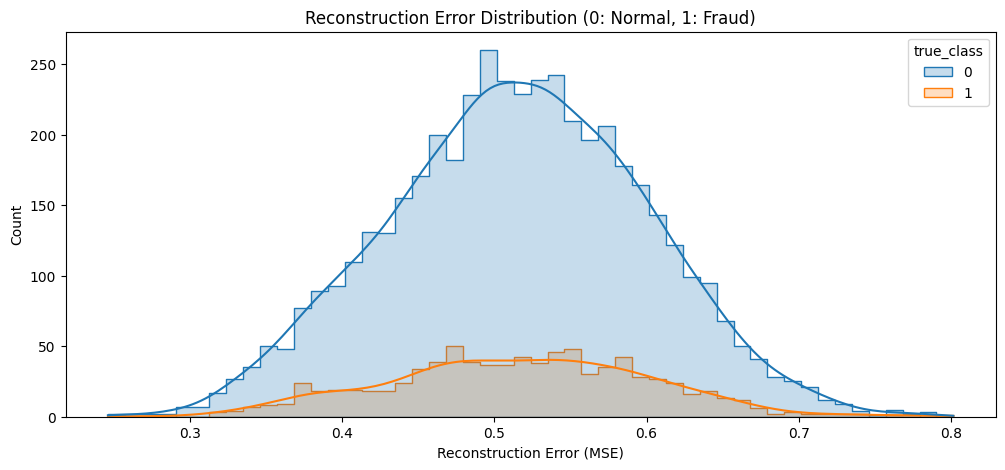

Selected Threshold: 0.6524

=== Classification Report ===
              precision    recall  f1-score   support

      Normal       0.84      0.95      0.89      4655
       Fraud       0.14      0.05      0.07       851

    accuracy                           0.81      5506
   macro avg       0.49      0.50      0.48      5506
weighted avg       0.74      0.81      0.77      5506


Confusion Matrix:
[[4422  233]
 [ 812   39]]


In [16]:
model.eval()
reconstruction_losses = []

with torch.no_grad():
    # 테스트 데이터를 배치 단위가 아니라 전체를 한 번에 넣어서 각 샘플별 Loss 계산
    # (메모리 부족 시 배치로 나눠서 해야 함)
    reconstructed, original = model(X_num_test, X_cat_test)

    # 각 샘플(시퀀스)별로 MSE Loss 계산
    # shape: (Batch, Seq, Feature) -> (Batch, )
    loss_per_sample = torch.mean((reconstructed - original)**2, dim=[1, 2])
    reconstruction_losses = loss_per_sample.cpu().numpy()

# 결과 분석을 위한 데이터프레임
res_df = pd.DataFrame({
    'reconstruction_error': reconstruction_losses,
    'true_class': y_test
})

# --- 시각화: 정상 vs 사기 오차 분포 ---
plt.figure(figsize=(12, 5))
sns.histplot(data=res_df, x='reconstruction_error', hue='true_class', bins=50, kde=True, element="step")
plt.title("Reconstruction Error Distribution (0: Normal, 1: Fraud)")
plt.xlabel("Reconstruction Error (MSE)")
plt.show()

# --- Threshold 설정 및 성능 평가 ---
# 방법: 정상 데이터 오차의 상위 95% 지점 등을 임계값으로 설정
threshold = np.percentile(res_df[res_df['true_class']==0]['reconstruction_error'], 95)
print(f"Selected Threshold: {threshold:.4f}")

# 예측 (임계값보다 오차가 크면 사기(1), 아니면 정상(0))
pred_y = (res_df['reconstruction_error'] > threshold).astype(int)

from sklearn.metrics import classification_report, confusion_matrix
print("\n=== Classification Report ===")
print(classification_report(res_df['true_class'], pred_y, target_names=['Normal', 'Fraud']))

print("\nConfusion Matrix:")
print(confusion_matrix(res_df['true_class'], pred_y))